In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

In [3]:
df = pd.read_csv('Exercise1 - data.csv', header=None)

In [4]:
# Convert malignant and benign to numerical values: Malilgnant to 1 and Benign to 0
df[1] = df[1].map({'M':1, 'B':0})

In [5]:
# Randomly choose 80% of the dataset for training, use the rest for testing
train_dataset = df.sample(frac=0.8, random_state=1)
test_dataset = df.drop(train_dataset.index)

In [6]:
# Generates descriptive statistics that summarize the central tendency, 
# dispersion and shape of a dataset's distribution, excluding NaN values
train_stats = train_dataset.describe()
train_stats.pop(0)
train_stats.pop(1)
train_stats = train_stats.transpose()

In [7]:
# Split features from labels
train_labels = train_dataset.pop(1)
test_labels = test_dataset.pop(1)
# Get rid of the ids - they are not relevant for classification
train_dataset.pop(0)
test_dataset.pop(0)
# Make sure the labels are treated as 2d arrays that can be fed into placeholder for Y
# Transpose to keep the 'vertical' shape
train_labels = np.transpose(np.atleast_2d(train_labels))
test_labels = np.transpose(np.atleast_2d(test_labels))

In [8]:
# Normalize the data using mean and standard deviation - intentionally use stats
# from only the training set, these statistics will aslo be used for evaluation.
# This is so that the model doesn't have any information about the test set.
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [9]:
# Insert a column with constant value for the constant parameter in classification
normed_train_data.insert(0, column='CONST', value=1)
normed_test_data.insert(0, column='CONST', value=1)

In [10]:
n_dim = normed_train_data.shape
n_dim

(455, 31)

In [55]:
# Parameters 
learning_rate = 0.0001
training_epochs = 1000
cost_history = np.empty(shape=[1], dtype=float)
epsilon = 10e-6
# Graph input and model weights
X = tf.placeholder(tf.float32, [None, n_dim[1]])
Y = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.ones([n_dim[1] ,1]))

init = tf.global_variables_initializer()

In [66]:
# Multiply features matrix to weights matrix and can be used for prediction
y_ = tf.nn.sigmoid(tf.matmul(X, W))
# Minimize error using cross entropy
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=Y))
# Perform one step of gradient descent optimisation to minimise the cost fucntion
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [67]:
# Training of the linear regression model
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={X:normed_train_data,Y:train_labels})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X:normed_train_data,Y:train_labels}))

[4.         0.61762387 0.61762381 0.61762381 0.61762381 0.61762369
 0.61762369 0.61762363 0.61762351 0.61762351]


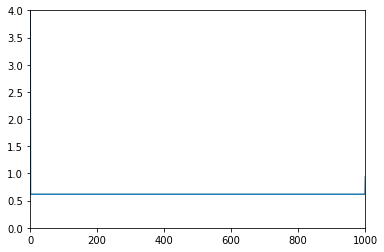

In [68]:
plt.plot(range(len(cost_history)),cost_history)
print(cost_history[:10])
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 0.6053


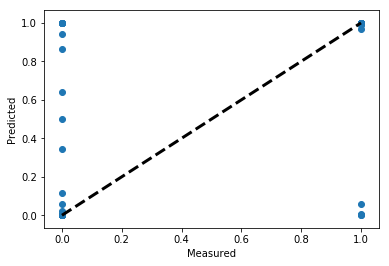

In [71]:
pred_y = sess.run(y_, feed_dict={X:normed_test_data})
pred_y_train = sess.run(y_, feed_dict={X:normed_train_data})
mse = tf.reduce_mean(tf.square(pred_y[0] - test_labels))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_labels, pred_y)
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [73]:
TP = 0
TN = 0
FP = 0
FN = 0
i = 0
for result in pred_y:
    if result>0.5 and test_labels[i]==1:
        TP+=1
    if result>0.5 and test_labels[i]==0:
        FP+=1
    if result<0.5 and test_labels[i]==1:
        FN+=1
    if result<0.5 and test_labels[i]==0:
        TN+=1
    i+=1
print([TN, FP])
print([FN, TP])

[59, 10]
[4, 41]


In [84]:
precision = round(TP/(TP+FP), 2)
recall = round(TP/(TP+FN),2)
F1 = round(2*precision*recall/(precision+recall),2)
accuracy = round((TP+TN)/(TP+FP+FN+TN), 2)
print('Precision: ',precision,'\nRecall: ',recall,'\nF1: ',F1,'\nAccuracy:', accuracy)


Precision:  0.8 
Recall:  0.91 
F1:  0.85 
Accuracy: 0.88
